In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os
import sys
from astropy.table import Table
from astropy.io import fits
import astropy.cosmology
from astropy import units as u
from astropy.coordinates import SkyCoord, Angle
import healpy as hp
from healpy.newvisufunc import projview, newprojplot

sys.path.insert(0, '/home/aew492/lss-dipoles')
from dipole import dipole, thetaphi_to_radec

### load QUaia catalog

In [3]:
quasar_fn = '/scratch/aew492/quasars/catalogs/catalog_G20.0.fits'  # clean G<20.0
data_quaia = Table.read(quasar_fn, format='fits')
# equatorial coordinates
ra, dec = data_quaia['ra'], data_quaia['dec']

In [4]:
# format into healpy map
NSIDE = 128
NPIX = hp.nside2npix(NSIDE)
print(NPIX)
pix_idx = hp.ang2pix(NSIDE, ra, dec, lonlat=True)  # get pixel locations of each quasar
map_data = np.bincount(pix_idx, minlength=NPIX)  # bin these pixel indices to get qso number density in each pixel

196608


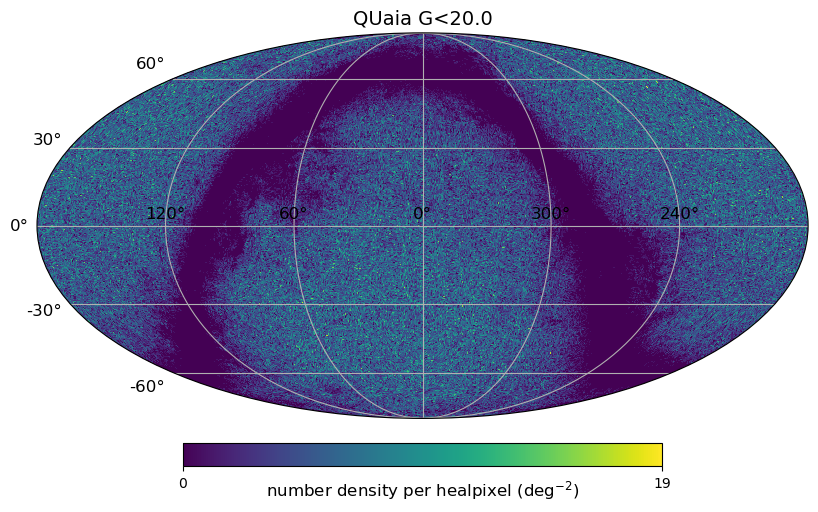

In [5]:
projview(map_data, title='QUaia G<20.0', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['E'], graticule=True, graticule_labels=True)

### fit dipole

In [6]:
# fit monopole and dipole:
map_data = [float(pix) for pix in map_data]  # need to convert all entries to floats to avoid error in remove_dipole()
map_nodip, monop, dipamps = hp.pixelfunc.remove_dipole(map_data, fitval=True)
print("monopole: ", monop)
print("dipole: ", dipamps)

monopole:  3.844451904296875
dipole:  [-0.27434286  0.17463296  0.03163161]


In [7]:
# get (RA,Dec) of the pixel locations
theta, phi = hp.pix2ang(NSIDE, ipix=np.arange(NPIX))
min(theta), max(theta), min(phi), max(phi)

(0.006378890353433737, 3.1352137632363597, 0.0, 6.277049384028044)

In [8]:
ra, dec = thetaphi_to_radec(theta, phi)

In [9]:
min(ra), max(ra), min(dec), max(dec)

(0.3654834952284671, 179.63451650477154, -269.6484375, 90.0)

In [10]:
expected_dipole = dipole(ra, dec, dipamps)

In [11]:
expected_dipole.shape

(196608,)

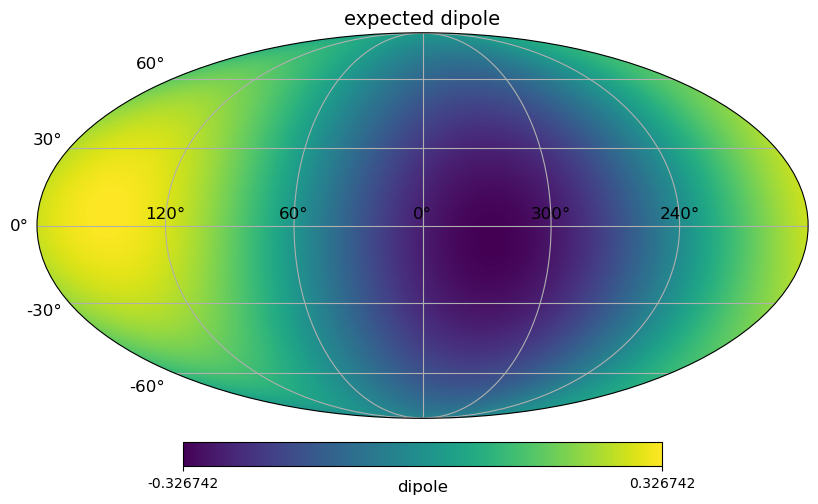

In [12]:
projview(expected_dipole, title='expected dipole', projection_type='mollweide',
            unit=r"dipole", coord=['E'], graticule=True, graticule_labels=True)

#### check $\Rightarrow$ `dipole = map - map_nodip - monopole`

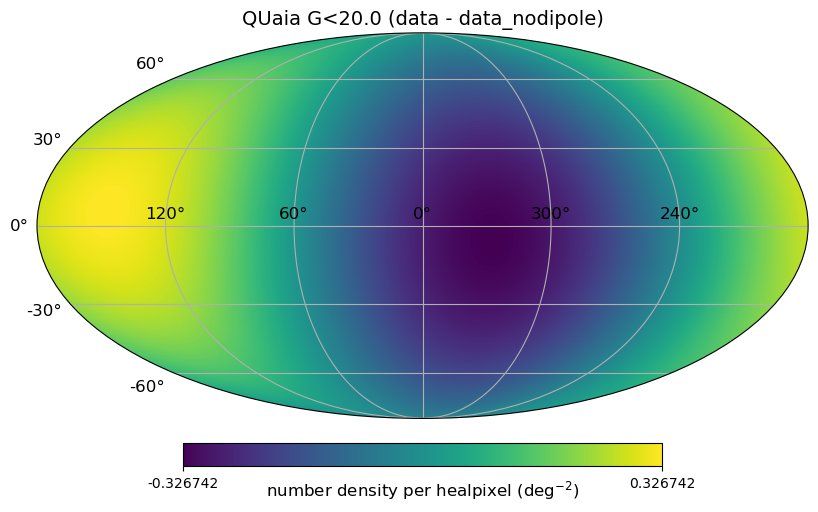

In [14]:
projview(map_data-map_nodip-monop, title='QUaia G<20.0 (data - data_nodipole)', projection_type='mollweide',
            unit=r"number density per healpixel (deg$^{-2}$)", coord=['E'],
         graticule=True, graticule_labels=True, flip='astro')